# Explore players dataset

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
elif PROJECT_ROOT.name.startswith("0"):
    PROJECT_ROOT = PROJECT_ROOT.parent.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn import model_selection
import xgboost as xgb

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from match_forecast.utils import *

2025-04-16 12:38:54.588 | INFO     | match_forecast.config:<module>:11 - PROJ_ROOT path is: /Users/maichoun/QRT-Challenge-2024


In [3]:
PROJ_ROOT = Path("QRT-Challenge-2024").resolve().parents[1]
DATA_DIR = PROJ_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
INTERIM_DATA_DIR = DATA_DIR / "interim"

In [4]:
try:
    train_home_player_statistics_df = pd.read_csv(RAW_DATA_DIR / "train_home_player_statistics_df.csv", index_col=0)
    train_away_player_statistics_df = pd.read_csv(RAW_DATA_DIR / "train_away_player_statistics_df.csv", index_col=0)
    train_scores = pd.read_csv(RAW_DATA_DIR / "Y_train.csv", index_col=0)
    print("Files loaded")
    
except FileNotFoundError as e:
    print(e)

Files loaded


In [5]:
train_home_player_statistics_df.shape

(237079, 306)

In [6]:
# 'LEAGUE', 'TEAM_NAME' et 'PLAYER_NAME' not included
home_players = train_home_player_statistics_df.drop(columns=['LEAGUE', 'PLAYER_NAME', 'TEAM_NAME'], axis=1)
away_players = train_away_player_statistics_df.drop(columns=['LEAGUE', 'PLAYER_NAME', 'TEAM_NAME'], axis=1)

# Rename
home_players.columns = 'HOME_' + home_players.columns
away_players.columns = 'AWAY_' + away_players.columns

home_players = home_players.apply(replace_null_values)
away_players = away_players.apply(replace_null_values)

print(home_players.shape)
print(away_players.shape) 

(237079, 303)
(236132, 303)


In [7]:
# Delete if NaNs% > 50%
print_perc_nans(home_players, threshold=50)
print_perc_nans(away_players, threshold=50)

HOME_PLAYER_CAPTAIN_season_sum: 89.33% missing
HOME_PLAYER_PUNCHES_season_sum: 71.54% missing
HOME_PLAYER_LONG_BALLS_season_sum: 100.00% missing
HOME_PLAYER_LONG_BALLS_WON_season_sum: 100.00% missing
HOME_PLAYER_SHOTS_OFF_TARGET_season_sum: 100.00% missing
HOME_PLAYER_CAPTAIN_season_average: 100.00% missing
HOME_PLAYER_PUNCHES_season_average: 71.54% missing
HOME_PLAYER_LONG_BALLS_season_average: 100.00% missing
HOME_PLAYER_LONG_BALLS_WON_season_average: 100.00% missing
HOME_PLAYER_SHOTS_OFF_TARGET_season_average: 100.00% missing
HOME_PLAYER_CAPTAIN_season_std: 100.00% missing
HOME_PLAYER_PUNCHES_season_std: 71.95% missing
HOME_PLAYER_LONG_BALLS_season_std: 100.00% missing
HOME_PLAYER_LONG_BALLS_WON_season_std: 100.00% missing
HOME_PLAYER_SHOTS_OFF_TARGET_season_std: 100.00% missing
HOME_PLAYER_CAPTAIN_5_last_match_sum: 92.38% missing
HOME_PLAYER_PUNCHES_5_last_match_sum: 71.54% missing
HOME_PLAYER_LONG_BALLS_5_last_match_sum: 100.00% missing
HOME_PLAYER_LONG_BALLS_WON_5_last_match_sum:

In [8]:
home_players = home_players.drop(columns=home_players.columns[home_players.isna().mean() > 0.5])
away_players = away_players.drop(columns=away_players.columns[away_players.isna().mean() > 0.5])

In [9]:
print_perc_nans(home_players, threshold=50)
print_perc_nans(away_players, threshold=50)

No columns have a percentage of NaN values above the threshold.
No columns have a percentage of NaN values above the threshold.


In [10]:
# Imputation for the rest
home_players = home_players.fillna({'HOME_POSITION': home_players['HOME_POSITION'].mode()[0]})
home_players = home_players.fillna(home_players.select_dtypes(include=['number']).median())

away_players = away_players.fillna({'AWAY_POSITION': away_players['AWAY_POSITION'].mode()[0]})
away_players = away_players.fillna(away_players.select_dtypes(include=['number']).median())

In [11]:
print_perc_nans(home_players, threshold=0)
print_perc_nans(away_players, threshold=0)

No columns have a percentage of NaN values above the threshold.
No columns have a percentage of NaN values above the threshold.


In [12]:
home_players.head()

,HOME_POSITION,HOME_PLAYER_ACCURATE_CROSSES_season_sum,HOME_PLAYER_ACCURATE_PASSES_season_sum,HOME_PLAYER_AERIALS_WON_season_sum,HOME_PLAYER_ASSISTS_season_sum,HOME_PLAYER_BIG_CHANCES_CREATED_season_sum,HOME_PLAYER_BIG_CHANCES_MISSED_season_sum,HOME_PLAYER_BLOCKED_SHOTS_season_sum,HOME_PLAYER_CLEARANCES_season_sum,HOME_PLAYER_CLEARANCE_OFFLINE_season_sum,HOME_PLAYER_DISPOSSESSED_season_sum,HOME_PLAYER_DRIBBLED_ATTEMPTS_season_sum,HOME_PLAYER_DRIBBLED_PAST_season_sum,HOME_PLAYER_DUELS_LOST_season_sum,HOME_PLAYER_DUELS_WON_season_sum,HOME_PLAYER_ERROR_LEAD_TO_GOAL_season_sum,HOME_PLAYER_FOULS_season_sum,HOME_PLAYER_FOULS_DRAWN_season_sum,HOME_PLAYER_GOALKEEPER_GOALS_CONCEDED_season_sum,HOME_PLAYER_GOALS_season_sum,HOME_PLAYER_GOALS_CONCEDED_season_sum,HOME_PLAYER_HIT_WOODWORK_season_sum,HOME_PLAYER_INTERCEPTIONS_season_sum,HOME_PLAYER_KEY_PASSES_season_sum,HOME_PLAYER_MINUTES_PLAYED_season_sum,HOME_PLAYER_OFFSIDES_season_sum,HOME_PLAYER_OWN_GOALS_season_sum,HOME_PLAYER_PASSES_season_sum,HOME_PLAYER_PENALTIES_COMMITTED_season_sum,HOME_PLAYER_PENALTIES_MISSES_season_sum,HOME_PLAYER_PENALTIES_SAVED_season_sum,HOME_PLAYER_PENALTIES_SCORED_season_sum,HOME_PLAYER_PENALTIES_WON_season_sum,HOME_PLAYER_REDCARDS_season_sum,HOME_PLAYER_SAVES_season_sum,HOME_PLAYER_SAVES_INSIDE_BOX_season_sum,HOME_PLAYER_SHOTS_BLOCKED_season_sum,HOME_PLAYER_SHOTS_ON_TARGET_season_sum,HOME_PLAYER_SHOTS_TOTAL_season_sum,HOME_PLAYER_STARTING_LINEUP_season_sum,HOME_PLAYER_SUCCESSFUL_DRIBBLES_season_sum,HOME_PLAYER_TACKLES_season_sum,HOME_PLAYER_TOTAL_CROSSES_season_sum,HOME_PLAYER_TOTAL_DUELS_season_sum,HOME_PLAYER_YELLOWCARDS_season_sum,HOME_PLAYER_ACCURATE_CROSSES_season_average,HOME_PLAYER_ACCURATE_PASSES_season_average,HOME_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_average,HOME_PLAYER_AERIALS_WON_season_average,HOME_PLAYER_ASSISTS_season_average,HOME_PLAYER_BIG_CHANCES_CREATED_season_average,HOME_PLAYER_BIG_CHANCES_MISSED_season_average,HOME_PLAYER_BLOCKED_SHOTS_season_average,HOME_PLAYER_CLEARANCES_season_average,HOME_PLAYER_CLEARANCE_OFFLINE_season_average,HOME_PLAYER_DISPOSSESSED_season_average,HOME_PLAYER_DRIBBLED_ATTEMPTS_season_average,HOME_PLAYER_DRIBBLED_PAST_season_average,HOME_PLAYER_DUELS_LOST_season_average,HOME_PLAYER_DUELS_WON_season_average,HOME_PLAYER_ERROR_LEAD_TO_GOAL_season_average,HOME_PLAYER_FOULS_season_average,HOME_PLAYER_FOULS_DRAWN_season_average,HOME_PLAYER_GOALKEEPER_GOALS_CONCEDED_season_average,HOME_PLAYER_GOALS_season_average,HOME_PLAYER_GOALS_CONCEDED_season_average,HOME_PLAYER_HIT_WOODWORK_season_average,HOME_PLAYER_INTERCEPTIONS_season_average,HOME_PLAYER_KEY_PASSES_season_average,HOME_PLAYER_MINUTES_PLAYED_season_average,HOME_PLAYER_OFFSIDES_season_average,HOME_PLAYER_OWN_GOALS_season_average,HOME_PLAYER_PASSES_season_average,HOME_PLAYER_PENALTIES_COMMITTED_season_average,HOME_PLAYER_PENALTIES_MISSES_season_average,HOME_PLAYER_PENALTIES_SAVED_season_average,HOME_PLAYER_PENALTIES_SCORED_season_average,HOME_PLAYER_PENALTIES_WON_season_average,HOME_PLAYER_RATING_season_average,HOME_PLAYER_REDCARDS_season_average,HOME_PLAYER_SAVES_season_average,HOME_PLAYER_SAVES_INSIDE_BOX_season_average,HOME_PLAYER_SHOTS_BLOCKED_season_average,HOME_PLAYER_SHOTS_ON_TARGET_season_average,HOME_PLAYER_SHOTS_TOTAL_season_average,HOME_PLAYER_STARTING_LINEUP_season_average,HOME_PLAYER_SUCCESSFUL_DRIBBLES_season_average,HOME_PLAYER_TACKLES_season_average,HOME_PLAYER_TOTAL_CROSSES_season_average,HOME_PLAYER_TOTAL_DUELS_season_average,HOME_PLAYER_YELLOWCARDS_season_average,HOME_PLAYER_ACCURATE_CROSSES_season_std,HOME_PLAYER_ACCURATE_PASSES_season_std,HOME_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_std,HOME_PLAYER_AERIALS_WON_season_std,HOME_PLAYER_ASSISTS_season_std,HOME_PLAYER_BIG_CHANCES_CREATED_season_std,HOME_PLAYER_BIG_CHANCES_MISSED_season_std,HOME_PLAYER_BLOCKED_SHOTS_season_std,HOME_PLAYER_CLEARANCES_season_std,HOME_PLAYER_CLEARANCE_OFFLINE_season_std,HOME_PLAYER_DISPOSSESSED_season_std,HOME_PLAYER_DRIBBLED_ATTEMPTS_season_std,HOME_PLAYER_DRIBBLED

### Sum

In [13]:
columns_to_aggregate_home = [col for col in home_players.columns if col.endswith(('average'))]
columns_to_aggregate_away = [col for col in away_players.columns if col.endswith(('average'))]

In [14]:
# Building tables
home_agg = home_players.groupby([home_players.index, 'HOME_POSITION']).agg({
    col: ['mean'] for col in columns_to_aggregate_home
}).reset_index()

away_agg = away_players.groupby([away_players.index, 'AWAY_POSITION']).agg({
    col: ['mean'] for col in columns_to_aggregate_away
}).reset_index()


In [15]:
home_agg.head()

,ID,HOME_POSITION,HOME_PLAYER_ACCURATE_CROSSES_season_average,HOME_PLAYER_ACCURATE_PASSES_season_average,HOME_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_average,HOME_PLAYER_AERIALS_WON_season_average,HOME_PLAYER_ASSISTS_season_average,HOME_PLAYER_BIG_CHANCES_CREATED_season_average,HOME_PLAYER_BIG_CHANCES_MISSED_season_average,HOME_PLAYER_BLOCKED_SHOTS_season_average,HOME_PLAYER_CLEARANCES_season_average,HOME_PLAYER_CLEARANCE_OFFLINE_season_average,HOME_PLAYER_DISPOSSESSED_season_average,HOME_PLAYER_DRIBBLED_ATTEMPTS_season_average,HOME_PLAYER_DRIBBLED_PAST_season_average,HOME_PLAYER_DUELS_LOST_season_average,HOME_PLAYER_DUELS_WON_season_average,HOME_PLAYER_ERROR_LEAD_TO_GOAL_season_average,HOME_PLAYER_FOULS_season_average,HOME_PLAYER_FOULS_DRAWN_season_average,HOME_PLAYER_GOALKEEPER_GOALS_CONCEDED_season_average,HOME_PLAYER_GOALS_season_average,HOME_PLAYER_GOALS_CONCEDED_season_average,HOME_PLAYER_HIT_WOODWORK_season_average,HOME_PLAYER_INTERCEPTIONS_season_average,HOME_PLAYER_KEY_PASSES_season_average,HOME_PLAYER_MINUTES_PLAYED_season_average,HOME_PLAYER_OFFSIDES_season_average,HOME_PLAYER_OWN_GOALS_season_average,HOME_PLAYER_PASSES_season_average,HOME_PLAYER_PENALTIES_COMMITTED_season_average,HOME_PLAYER_PENALTIES_MISSES_season_average,HOME_PLAYER_PENALTIES_SAVED_season_average,HOME_PLAYER_PENALTIES_SCORED_season_average,HOME_PLAYER_PENALTIES_WON_season_average,HOME_PLAYER_RATING_season_average,HOME_PLAYER_REDCARDS_season_average,HOME_PLAYER_SAVES_season_average,HOME_PLAYER_SAVES_INSIDE_BOX_season_average,HOME_PLAYER_SHOTS_BLOCKED_season_average,HOME_PLAYER_SHOTS_ON_TARGET_season_average,HOME_PLAYER_SHOTS_TOTAL_season_average,HOME_PLAYER_STARTING_LINEUP_season_average,HOME_PLAYER_SUCCESSFUL_DRIBBLES_season_average,HOME_PLAYER_TACKLES_season_average,HOME_PLAYER_TOTAL_CROSSES_season_average,HOME_PLAYER_TOTAL_DUELS_season_average,HOME_PLAYER_YELLOWCARDS_season_average,HOME_PLAYER_ACCURATE_CROSSES_5_last_match_average,HOME_PLAYER_ACCURATE_PASSES_5_last_match_average,HOME_PLAYER_ACCURATE_PASSES_PERCENTAGE_5_last_match_average,HOME_PLAYER_AERIALS_WON_5_last_match_average,HOME_PLAYER_ASSISTS_5_last_match_average,HOME_PLAYER_BIG_CHANCES_CREATED_5_last_match_average,HOME_PLAYER_BIG_CHANCES_MISSED_5_last_match_average,HOME_PLAYER_BLOCKED_SHOTS_5_last_match_average,HOME_PLAYER_CLEARANCES_5_last_match_average,HOME_PLAYER_CLEARANCE_OFFLINE_5_last_match_average,HOME_PLAYER_DISPOSSESSED_5_last_match_average,HOME_PLAYER_DRIBBLED_ATTEMPTS_5_last_match_average,HOME_PLAYER_DRIBBLED_PAST_5_last_match_average,HOME_PLAYER_DUELS_LOST_5_last_match_average,HOME_PLAYER_DUELS_WON_5_last_match_average,HOME_PLAYER_ERROR_LEAD_TO_GOAL_5_last_match_average,HOME_PLAYER_FOULS_5_last_match_average,HOME_PLAYER_FOULS_DRAWN_5_last_match_average,HOME_PLAYER_GOALKEEPER_GOALS_CONCEDED_5_last_match_average,HOME_PLAYER_GOALS_5_last_match_average,HOME_PLAYER_GOALS_CONCEDED_5_last_match_average,HOME_PLAYER_HIT_WOODWORK_5_last_match_average,HOME_PLAYER_INTERCEPTIONS_5_last_match_average,HOME_PLAYER_KEY_PASSES_5_last_match_average,HOME_PLAYER_MINUTES_PLAYED_5_last_match_average,HOME_PLAYER_OFFSIDES_5_last_match_average,HOME_PLAYER_OWN_GOALS_5_last_match_average,HOME_PLAYER_PASSES_5_last_match_average,HOME_PLAYER_PENALTIES_COMMITTED_5_last_match_average,HOME_PLAYER_PENALTIES_MISSES_5_last_match_average,HOME_PLAYER_PENALTIES_SAVED_5_last_match_average,HOME_PLAYER_PENALTIES_SCORED_5_last_match_average,HOME_PLAYER_PENALTIES_WON_5_last_match_average,HOME_PLAYER_RATING_5_last_match_average,HOME_PLAYER_REDCARDS_5_last_match_average,HOME_PLAYER_SAVES_5_last_match_average,HOME_PLAYER_SAVES_INSIDE_BOX_5_last_match_average,HOME_PLAYER_SHOTS_BLOCKED_5_last_match_average,HOME_PLAYER_SHOTS_ON_TARGET_5_last_match_average,HOME_PLAYER_SHOTS_TOTAL_5_last_match_average,HOME_PLAYER_STARTING_LINEUP_5_last_match_average,HOME_PLAYER_SUCCESSFUL_DRIBBLES_5_last_match_average,HOME_PLAYER_TACKLES_5_last_match_average,HOME_PLAYER_TOTAL_CROSSES_5_last_match_average,HOME_PLAYER_TOTAL_DUELS_5_last_match

In [16]:
# Flatten multi-level columns from previous groupby
home_agg.columns = ['_'.join(col).strip() for col in home_agg.columns.values]
home_agg = home_agg.rename(columns={'ID_' : 'HOME_ID', 'HOME_POSITION_' : 'HOME_POSITION'})

away_agg.columns = ['_'.join(col).strip() for col in away_agg.columns.values]
away_agg = away_agg.rename(columns={'ID_' : 'AWAY_ID', 'AWAY_POSITION_' : 'AWAY_POSITION'})

In [17]:
home_agg.tail()

,HOME_ID,HOME_POSITION,HOME_PLAYER_ACCURATE_CROSSES_season_average_mean,HOME_PLAYER_ACCURATE_PASSES_season_average_mean,HOME_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_average_mean,HOME_PLAYER_AERIALS_WON_season_average_mean,HOME_PLAYER_ASSISTS_season_average_mean,HOME_PLAYER_BIG_CHANCES_CREATED_season_average_mean,HOME_PLAYER_BIG_CHANCES_MISSED_season_average_mean,HOME_PLAYER_BLOCKED_SHOTS_season_average_mean,HOME_PLAYER_CLEARANCES_season_average_mean,HOME_PLAYER_CLEARANCE_OFFLINE_season_average_mean,HOME_PLAYER_DISPOSSESSED_season_average_mean,HOME_PLAYER_DRIBBLED_ATTEMPTS_season_average_mean,HOME_PLAYER_DRIBBLED_PAST_season_average_mean,HOME_PLAYER_DUELS_LOST_season_average_mean,HOME_PLAYER_DUELS_WON_season_average_mean,HOME_PLAYER_ERROR_LEAD_TO_GOAL_season_average_mean,HOME_PLAYER_FOULS_season_average_mean,HOME_PLAYER_FOULS_DRAWN_season_average_mean,HOME_PLAYER_GOALKEEPER_GOALS_CONCEDED_season_average_mean,HOME_PLAYER_GOALS_season_average_mean,HOME_PLAYER_GOALS_CONCEDED_season_average_mean,HOME_PLAYER_HIT_WOODWORK_season_average_mean,HOME_PLAYER_INTERCEPTIONS_season_average_mean,HOME_PLAYER_KEY_PASSES_season_average_mean,HOME_PLAYER_MINUTES_PLAYED_season_average_mean,HOME_PLAYER_OFFSIDES_season_average_mean,HOME_PLAYER_OWN_GOALS_season_average_mean,HOME_PLAYER_PASSES_season_average_mean,HOME_PLAYER_PENALTIES_COMMITTED_season_average_mean,HOME_PLAYER_PENALTIES_MISSES_season_average_mean,HOME_PLAYER_PENALTIES_SAVED_season_average_mean,HOME_PLAYER_PENALTIES_SCORED_season_average_mean,HOME_PLAYER_PENALTIES_WON_season_average_mean,HOME_PLAYER_RATING_season_average_mean,HOME_PLAYER_REDCARDS_season_average_mean,HOME_PLAYER_SAVES_season_average_mean,HOME_PLAYER_SAVES_INSIDE_BOX_season_average_mean,HOME_PLAYER_SHOTS_BLOCKED_season_average_mean,HOME_PLAYER_SHOTS_ON_TARGET_season_average_mean,HOME_PLAYER_SHOTS_TOTAL_season_average_mean,HOME_PLAYER_STARTING_LINEUP_season_average_mean,HOME_PLAYER_SUCCESSFUL_DRIBBLES_season_average_mean,HOME_PLAYER_TACKLES_season_average_mean,HOME_PLAYER_TOTAL_CROSSES_season_average_mean,HOME_PLAYER_TOTAL_DUELS_season_average_mean,HOME_PLAYER_YELLOWCARDS_season_average_mean,HOME_PLAYER_ACCURATE_CROSSES_5_last_match_average_mean,HOME_PLAYER_ACCURATE_PASSES_5_last_match_average_mean,HOME_PLAYER_ACCURATE_PASSES_PERCENTAGE_5_last_match_average_mean,HOME_PLAYER_AERIALS_WON_5_last_match_average_mean,HOME_PLAYER_ASSISTS_5_last_match_average_mean,HOME_PLAYER_BIG_CHANCES_CREATED_5_last_match_average_mean,HOME_PLAYER_BIG_CHANCES_MISSED_5_last_match_average_mean,HOME_PLAYER_BLOCKED_SHOTS_5_last_match_average_mean,HOME_PLAYER_CLEARANCES_5_last_match_average_mean,HOME_PLAYER_CLEARANCE_OFFLINE_5_last_match_average_mean,HOME_PLAYER_DISPOSSESSED_5_last_match_average_mean,HOME_PLAYER_DRIBBLED_ATTEMPTS_5_last_match_average_mean,HOME_PLAYER_DRIBBLED_PAST_5_last_match_average_mean,HOME_PLAYER_DUELS_LOST_5_last_match_average_mean,HOME_PLAYER_DUELS_WON_5_last_match_average_mean,HOME_PLAYER_ERROR_LEAD_TO_GOAL_5_last_match_average_mean,HOME_PLAYER_FOULS_5_last_match_average_mean,HOME_PLAYER_FOULS_DRAWN_5_last_match_average_mean,HOME_PLAYER_GOALKEEPER_GOALS_CONCEDED_5_last_match_average_mean,HOME_PLAYER_GOALS_5_last_match_average_mean,HOME_PLAYER_GOALS_CONCEDED_5_last_match_average_mean,HOME_PLAYER_HIT_WOODWORK_5_last_match_average_mean,HOME_PLAYER_INTERCEPTIONS_5_last_match_average_mean,HOME_PLAYER_KEY_PASSES_5_last_match_average_mean,HOME_PLAYER_MINUTES_PLAYED_5_last_match_average_mean,HOME_PLAYER_OFFSIDES_5_last_match_average_mean,HOME_PLAYER_OWN_GOALS_5_last_match_average_mean,HOME_PLAYER_PASSES_5_last_match_average_mean,HOME_PLAYER_PENALTIES_COMMITTED_5_last_match_average_mean,HOME_PLAYER_PENALTIES_MISSES_5_last_match_average_mean,HOME_PLAYER_PENALTIES_SAVED_5_last_match_average_mean,HOME_PLAYER_PENALTIES_SCORED_5_last_match_average_mean,HOME_PLAYER_PENALTIES_WON_5_last_match_average_mean,HOME_PLAYER_RATING_5_last_match_average_mean,HOME_PLAYER_REDCARDS_5_last_match_average_mean,HOME_PLAYER_SAVES_5_last_match_average_mean,HO

In [18]:
position_map = {
    'attacker': 'offensive',
    'midfielder': 'offensive',
    'defender': 'defensive',
    'goalkeeper': 'defensive'
}

In [19]:
# For home aggregation:
home_agg['position_group'] = home_agg['HOME_POSITION'].map(position_map)  # Map positions to groups
agg_columns = [col for col in home_agg.columns 
               if home_agg[col].dtype in ['float64', 'int64'] and col != 'HOME_ID']  # Select numeric columns
home_group = home_agg.groupby(['HOME_ID', 'position_group'])[agg_columns].mean().reset_index()  # Compute mean for each group

home_pivot = home_group.pivot(index='HOME_ID', columns='position_group')  # Pivot to get separate columns per group
home_pivot.columns = ['_'.join(col).strip() for col in home_pivot.columns.values]  # Flatten multi-level column index
home_pivot.reset_index(inplace=True)

# For away aggregation:
away_agg['position_group'] = away_agg['AWAY_POSITION'].map(position_map)  # Map positions to groups
agg_columns = [col for col in away_agg.columns 
               if away_agg[col].dtype in ['float64', 'int64'] and col != 'AWAY_ID']  # Select numeric columns
away_group = away_agg.groupby(['AWAY_ID', 'position_group'])[agg_columns].mean().reset_index()  # Compute mean for each group

away_pivot = away_group.pivot(index='AWAY_ID', columns='position_group')  # Pivot to get separate columns per group
away_pivot.columns = ['_'.join(col).strip() for col in away_pivot.columns.values]  # Flatten multi-level column index
away_pivot.reset_index(inplace=True)


In [20]:
home_pivot.head(5)

,HOME_ID,HOME_PLAYER_ACCURATE_CROSSES_season_average_mean_defensive,HOME_PLAYER_ACCURATE_CROSSES_season_average_mean_offensive,HOME_PLAYER_ACCURATE_PASSES_season_average_mean_defensive,HOME_PLAYER_ACCURATE_PASSES_season_average_mean_offensive,HOME_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_average_mean_defensive,HOME_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_average_mean_offensive,HOME_PLAYER_AERIALS_WON_season_average_mean_defensive,HOME_PLAYER_AERIALS_WON_season_average_mean_offensive,HOME_PLAYER_ASSISTS_season_average_mean_defensive,HOME_PLAYER_ASSISTS_season_average_mean_offensive,HOME_PLAYER_BIG_CHANCES_CREATED_season_average_mean_defensive,HOME_PLAYER_BIG_CHANCES_CREATED_season_average_mean_offensive,HOME_PLAYER_BIG_CHANCES_MISSED_season_average_mean_defensive,HOME_PLAYER_BIG_CHANCES_MISSED_season_average_mean_offensive,HOME_PLAYER_BLOCKED_SHOTS_season_average_mean_defensive,HOME_PLAYER_BLOCKED_SHOTS_season_average_mean_offensive,HOME_PLAYER_CLEARANCES_season_average_mean_defensive,HOME_PLAYER_CLEARANCES_season_average_mean_offensive,HOME_PLAYER_CLEARANCE_OFFLINE_season_average_mean_defensive,HOME_PLAYER_CLEARANCE_OFFLINE_season_average_mean_offensive,HOME_PLAYER_DISPOSSESSED_season_average_mean_defensive,HOME_PLAYER_DISPOSSESSED_season_average_mean_offensive,HOME_PLAYER_DRIBBLED_ATTEMPTS_season_average_mean_defensive,HOME_PLAYER_DRIBBLED_ATTEMPTS_season_average_mean_offensive,HOME_PLAYER_DRIBBLED_PAST_season_average_mean_defensive,HOME_PLAYER_DRIBBLED_PAST_season_average_mean_offensive,HOME_PLAYER_DUELS_LOST_season_average_mean_defensive,HOME_PLAYER_DUELS_LOST_season_average_mean_offensive,HOME_PLAYER_DUELS_WON_season_average_mean_defensive,HOME_PLAYER_DUELS_WON_season_average_mean_offensive,HOME_PLAYER_ERROR_LEAD_TO_GOAL_season_average_mean_defensive,HOME_PLAYER_ERROR_LEAD_TO_GOAL_season_average_mean_offensive,HOME_PLAYER_FOULS_season_average_mean_defensive,HOME_PLAYER_FOULS_season_average_mean_offensive,HOME_PLAYER_FOULS_DRAWN_season_average_mean_defensive,HOME_PLAYER_FOULS_DRAWN_season_average_mean_offensive,HOME_PLAYER_GOALKEEPER_GOALS_CONCEDED_season_average_mean_defensive,HOME_PLAYER_GOALKEEPER_GOALS_CONCEDED_season_average_mean_offensive,HOME_PLAYER_GOALS_season_average_mean_defensive,HOME_PLAYER_GOALS_season_average_mean_offensive,HOME_PLAYER_GOALS_CONCEDED_season_average_mean_defensive,HOME_PLAYER_GOALS_CONCEDED_season_average_mean_offensive,HOME_PLAYER_HIT_WOODWORK_season_average_mean_defensive,HOME_PLAYER_HIT_WOODWORK_season_average_mean_offensive,HOME_PLAYER_INTERCEPTIONS_season_average_mean_defensive,HOME_PLAYER_INTERCEPTIONS_season_average_mean_offensive,HOME_PLAYER_KEY_PASSES_season_average_mean_defensive,HOME_PLAYER_KEY_PASSES_season_average_mean_offensive,HOME_PLAYER_MINUTES_PLAYED_season_average_mean_defensive,HOME_PLAYER_MINUTES_PLAYED_season_average_mean_offensive,HOME_PLAYER_OFFSIDES_season_average_mean_defensive,HOME_PLAYER_OFFSIDES_season_average_mean_offensive,HOME_PLAYER_OWN_GOALS_season_average_mean_defensive,HOME_PLAYER_OWN_GOALS_season_average_mean_offensive,HOME_PLAYER_PASSES_season_average_mean_defensive,HOME_PLAYER_PASSES_season_average_mean_offensive,HOME_PLAYER_PENALTIES_COMMITTED_season_average_mean_defensive,HOME_PLAYER_PENALTIES_COMMITTED_season_average_mean_offensive,HOME_PLAYER_PENALTIES_MISSES_season_average_mean_defensive,HOME_PLAYER_PENALTIES_MISSES_season_average_mean_offensive,HOME_PLAYER_PENALTIES_SAVED_season_average_mean_defensive,HOME_PLAYER_PENALTIES_SAVED_season_average_mean_offensive,HOME_PLAYER_PENALTIES_SCORED_season_average_mean_defensive,HOME_PLAYER_PENALTIES_SCORED_season_average_mean_offensive,HOME_PLAYER_PENALTIES_WON_season_average_mean_defensive,HOME_PLAYER_PENALTIES_WON_season_average_mean_offensive,HOME_PLAYER_RATING_season_average_mean_defensive,HOME_PLAYER_RATING_season_average_mean_offensive,HOME_PLAYER_REDCARDS_season_average_mean_defensive,HOME_PLAYER_REDCARDS_season_average_mean_offensive,HOME_PLAYER_SAVES_season_average_mean_defensive,HOME_PLAYER_SAVES_sea

In [21]:
# Merge
home_pivot.rename(columns={'HOME_ID': 'ID'}, inplace=True)
away_pivot.rename(columns={'AWAY_ID': 'ID'}, inplace=True)
train_data_players = home_pivot.merge(away_pivot, on='ID', how='inner')
train_data_players.set_index('ID', inplace=True)


In [22]:
train_data_players.head()

,HOME_PLAYER_ACCURATE_CROSSES_season_average_mean_defensive,HOME_PLAYER_ACCURATE_CROSSES_season_average_mean_offensive,HOME_PLAYER_ACCURATE_PASSES_season_average_mean_defensive,HOME_PLAYER_ACCURATE_PASSES_season_average_mean_offensive,HOME_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_average_mean_defensive,HOME_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_average_mean_offensive,HOME_PLAYER_AERIALS_WON_season_average_mean_defensive,HOME_PLAYER_AERIALS_WON_season_average_mean_offensive,HOME_PLAYER_ASSISTS_season_average_mean_defensive,HOME_PLAYER_ASSISTS_season_average_mean_offensive,HOME_PLAYER_BIG_CHANCES_CREATED_season_average_mean_defensive,HOME_PLAYER_BIG_CHANCES_CREATED_season_average_mean_offensive,HOME_PLAYER_BIG_CHANCES_MISSED_season_average_mean_defensive,HOME_PLAYER_BIG_CHANCES_MISSED_season_average_mean_offensive,HOME_PLAYER_BLOCKED_SHOTS_season_average_mean_defensive,HOME_PLAYER_BLOCKED_SHOTS_season_average_mean_offensive,HOME_PLAYER_CLEARANCES_season_average_mean_defensive,HOME_PLAYER_CLEARANCES_season_average_mean_offensive,HOME_PLAYER_CLEARANCE_OFFLINE_season_average_mean_defensive,HOME_PLAYER_CLEARANCE_OFFLINE_season_average_mean_offensive,HOME_PLAYER_DISPOSSESSED_season_average_mean_defensive,HOME_PLAYER_DISPOSSESSED_season_average_mean_offensive,HOME_PLAYER_DRIBBLED_ATTEMPTS_season_average_mean_defensive,HOME_PLAYER_DRIBBLED_ATTEMPTS_season_average_mean_offensive,HOME_PLAYER_DRIBBLED_PAST_season_average_mean_defensive,HOME_PLAYER_DRIBBLED_PAST_season_average_mean_offensive,HOME_PLAYER_DUELS_LOST_season_average_mean_defensive,HOME_PLAYER_DUELS_LOST_season_average_mean_offensive,HOME_PLAYER_DUELS_WON_season_average_mean_defensive,HOME_PLAYER_DUELS_WON_season_average_mean_offensive,HOME_PLAYER_ERROR_LEAD_TO_GOAL_season_average_mean_defensive,HOME_PLAYER_ERROR_LEAD_TO_GOAL_season_average_mean_offensive,HOME_PLAYER_FOULS_season_average_mean_defensive,HOME_PLAYER_FOULS_season_average_mean_offensive,HOME_PLAYER_FOULS_DRAWN_season_average_mean_defensive,HOME_PLAYER_FOULS_DRAWN_season_average_mean_offensive,HOME_PLAYER_GOALKEEPER_GOALS_CONCEDED_season_average_mean_defensive,HOME_PLAYER_GOALKEEPER_GOALS_CONCEDED_season_average_mean_offensive,HOME_PLAYER_GOALS_season_average_mean_defensive,HOME_PLAYER_GOALS_season_average_mean_offensive,HOME_PLAYER_GOALS_CONCEDED_season_average_mean_defensive,HOME_PLAYER_GOALS_CONCEDED_season_average_mean_offensive,HOME_PLAYER_HIT_WOODWORK_season_average_mean_defensive,HOME_PLAYER_HIT_WOODWORK_season_average_mean_offensive,HOME_PLAYER_INTERCEPTIONS_season_average_mean_defensive,HOME_PLAYER_INTERCEPTIONS_season_average_mean_offensive,HOME_PLAYER_KEY_PASSES_season_average_mean_defensive,HOME_PLAYER_KEY_PASSES_season_average_mean_offensive,HOME_PLAYER_MINUTES_PLAYED_season_average_mean_defensive,HOME_PLAYER_MINUTES_PLAYED_season_average_mean_offensive,HOME_PLAYER_OFFSIDES_season_average_mean_defensive,HOME_PLAYER_OFFSIDES_season_average_mean_offensive,HOME_PLAYER_OWN_GOALS_season_average_mean_defensive,HOME_PLAYER_OWN_GOALS_season_average_mean_offensive,HOME_PLAYER_PASSES_season_average_mean_defensive,HOME_PLAYER_PASSES_season_average_mean_offensive,HOME_PLAYER_PENALTIES_COMMITTED_season_average_mean_defensive,HOME_PLAYER_PENALTIES_COMMITTED_season_average_mean_offensive,HOME_PLAYER_PENALTIES_MISSES_season_average_mean_defensive,HOME_PLAYER_PENALTIES_MISSES_season_average_mean_offensive,HOME_PLAYER_PENALTIES_SAVED_season_average_mean_defensive,HOME_PLAYER_PENALTIES_SAVED_season_average_mean_offensive,HOME_PLAYER_PENALTIES_SCORED_season_average_mean_defensive,HOME_PLAYER_PENALTIES_SCORED_season_average_mean_offensive,HOME_PLAYER_PENALTIES_WON_season_average_mean_defensive,HOME_PLAYER_PENALTIES_WON_season_average_mean_offensive,HOME_PLAYER_RATING_season_average_mean_defensive,HOME_PLAYER_RATING_season_average_mean_offensive,HOME_PLAYER_REDCARDS_season_average_mean_defensive,HOME_PLAYER_REDCARDS_season_average_mean_offensive,HOME_PLAYER_SAVES_season_average_mean_defensive,HOME_PLAYER_SAVES_season_aver

In [23]:
print_perc_nans(train_data_players, threshold=50)

No columns have a percentage of NaN values above the threshold.


In [24]:
train_data_players = train_data_players.drop(columns=train_data_players.columns[train_data_players.isna().mean() > 0.5])

In [25]:
print_perc_nans(train_data_players, threshold=0)

HOME_PLAYER_ACCURATE_CROSSES_season_average_mean_defensive: 6.96% missing
HOME_PLAYER_ACCURATE_PASSES_season_average_mean_defensive: 6.96% missing
HOME_PLAYER_ACCURATE_PASSES_PERCENTAGE_season_average_mean_defensive: 6.96% missing
HOME_PLAYER_AERIALS_WON_season_average_mean_defensive: 6.96% missing
HOME_PLAYER_ASSISTS_season_average_mean_defensive: 6.96% missing
HOME_PLAYER_BIG_CHANCES_CREATED_season_average_mean_defensive: 6.96% missing
HOME_PLAYER_BIG_CHANCES_MISSED_season_average_mean_defensive: 6.96% missing
HOME_PLAYER_BLOCKED_SHOTS_season_average_mean_defensive: 6.96% missing
HOME_PLAYER_CLEARANCES_season_average_mean_defensive: 6.96% missing
HOME_PLAYER_CLEARANCE_OFFLINE_season_average_mean_defensive: 6.96% missing
HOME_PLAYER_DISPOSSESSED_season_average_mean_defensive: 6.96% missing
HOME_PLAYER_DRIBBLED_ATTEMPTS_season_average_mean_defensive: 6.96% missing
HOME_PLAYER_DRIBBLED_PAST_season_average_mean_defensive: 6.96% missing
HOME_PLAYER_DUELS_LOST_season_average_mean_defensive

In [26]:
train_data_players = train_data_players.fillna(train_data_players.select_dtypes(include=['number']).median())

In [27]:
print_perc_nans(train_data_players, threshold=0)

No columns have a percentage of NaN values above the threshold.


In [28]:
print(train_data_players.shape)

(12303, 368)


### Feature Engineering

In [29]:
### DIFFERENCES
home_columns = [col for col in train_data_players.columns if col.startswith('HOME_PLAYER_')]
away_columns = [col for col in train_data_players.columns if col.startswith('AWAY_PLAYER_')]

common_columns = [(home, home.replace('HOME_PLAYER_', 'AWAY_PLAYER_')) for home in home_columns if home.replace('HOME_PLAYER_', 'AWAY_PLAYER_') in away_columns]

for home_col, away_col in common_columns:
    diff_col_name = home_col.replace('HOME_PLAYER_', 'DIFF_PLAYER_') 
    train_data_players[diff_col_name] = train_data_players[home_col] - train_data_players[away_col]

cols_to_drop = home_columns + away_columns
train_data_players.drop(columns=cols_to_drop, inplace=True)


### Average

In [30]:
# columns_to_aggregate_home = [col for col in home_players.columns if col.endswith(('average'))]
# columns_to_aggregate_away = [col for col in away_players.columns if col.endswith(('average'))]

# # Building tables
# home_agg = home_players.groupby([home_players.index, 'HOME_POSITION']).agg({
#     col: ['mean'] for col in columns_to_aggregate_home  # mean agg
# }).reset_index()

# away_agg = away_players.groupby([away_players.index, 'AWAY_POSITION']).agg({
#     col: ['mean'] for col in columns_to_aggregate_away  # mean agg
# }).reset_index()

# # Flatten multi-level columns from previous groupby
# home_agg.columns = ['_'.join(col).strip() for col in home_agg.columns.values]
# home_agg = home_agg.rename(columns={'ID_' : 'HOME_ID', 'HOME_POSITION_' : 'HOME_POSITION'})

# away_agg.columns = ['_'.join(col).strip() for col in away_agg.columns.values]
# away_agg = away_agg.rename(columns={'ID_' : 'AWAY_ID', 'AWAY_POSITION_' : 'AWAY_POSITION'})

# # Generate new col names
# columns_to_aggregate_home_expanded = []
# columns_to_aggregate_away_expanded = []

# for col in columns_to_aggregate_home:
#     columns_to_aggregate_home_expanded.extend([
#         f"{col}_mean", 
#     ])

# for col in columns_to_aggregate_away:
#     columns_to_aggregate_away_expanded.extend([
#         f"{col}_mean", 
#     ])

# # Home pivot and flatten multi-level
# home_pivot = home_agg.pivot(index='HOME_ID', columns='HOME_POSITION', values=columns_to_aggregate_home_expanded)
# home_pivot.columns = ['_'.join(col).strip() for col in home_pivot.columns.values]
# home_pivot.reset_index(inplace=True)

# # Away pivot and flatten multi-level
# away_pivot = away_agg.pivot(index='AWAY_ID', columns='AWAY_POSITION', values=columns_to_aggregate_away_expanded)
# away_pivot.columns = ['_'.join(col).strip() for col in away_pivot.columns.values]
# away_pivot.reset_index(inplace=True)

# # Merge
# home_pivot.rename(columns={'HOME_ID': 'ID'}, inplace=True)
# away_pivot.rename(columns={'AWAY_ID': 'ID'}, inplace=True)
# train_data_players_avg = home_pivot.merge(away_pivot, on='ID', how='inner')
# train_data_players_avg.set_index('ID', inplace=True)

# train_data_players_avg = train_data_players_avg.drop(columns=train_data_players_avg.columns[train_data_players_avg.isna().mean() > 0.5])
# train_data_players_avg = train_data_players_avg.fillna(train_data_players_avg.select_dtypes(include=['number']).median())

# ### DIFFERENCES
# home_columns = [col for col in train_data_players_avg.columns if col.startswith('HOME_PLAYER_')]
# away_columns = [col for col in train_data_players_avg.columns if col.startswith('AWAY_PLAYER_')]

# common_columns = [(home, home.replace('HOME_PLAYER_', 'AWAY_PLAYER_')) for home in home_columns if home.replace('HOME_PLAYER_', 'AWAY_PLAYER_') in away_columns]

# for home_col, away_col in common_columns:
#     diff_col_name = home_col.replace('HOME_PLAYER_', 'DIFF_PLAYER_') 
#     train_data_players_avg[diff_col_name] = train_data_players_avg[home_col] - train_data_players_avg[away_col]

# cols_to_drop = home_columns + away_columns
# train_data_players_avg.drop(columns=cols_to_drop, inplace=True)


In [31]:
# train_data_players = train_data_players.merge(train_data_players_avg, left_index=True, right_index=True, how='inner')

### Std

In [32]:
# columns_to_aggregate_home = [col for col in home_players.columns if col.endswith(('std'))]
# columns_to_aggregate_away = [col for col in away_players.columns if col.endswith(('std'))]

# # Building tables
# home_agg = home_players.groupby([home_players.index, 'HOME_POSITION']).agg({
#     col: ['mean'] for col in columns_to_aggregate_home  # mean agg
# }).reset_index()

# away_agg = away_players.groupby([away_players.index, 'AWAY_POSITION']).agg({
#     col: ['mean'] for col in columns_to_aggregate_away  # mean agg
# }).reset_index()

# # Flatten multi-level columns from previous groupby
# home_agg.columns = ['_'.join(col).strip() for col in home_agg.columns.values]
# home_agg = home_agg.rename(columns={'ID_' : 'HOME_ID', 'HOME_POSITION_' : 'HOME_POSITION'})

# away_agg.columns = ['_'.join(col).strip() for col in away_agg.columns.values]
# away_agg = away_agg.rename(columns={'ID_' : 'AWAY_ID', 'AWAY_POSITION_' : 'AWAY_POSITION'})

# # Generate new col names
# columns_to_aggregate_home_expanded = []
# columns_to_aggregate_away_expanded = []

# for col in columns_to_aggregate_home:
#     columns_to_aggregate_home_expanded.extend([
#         f"{col}_mean", 
#     ])

# for col in columns_to_aggregate_away:
#     columns_to_aggregate_away_expanded.extend([
#         f"{col}_mean", 
#     ])

# # Home pivot and flatten multi-level
# home_pivot = home_agg.pivot(index='HOME_ID', columns='HOME_POSITION', values=columns_to_aggregate_home_expanded)
# home_pivot.columns = ['_'.join(col).strip() for col in home_pivot.columns.values]
# home_pivot.reset_index(inplace=True)

# # Away pivot and flatten multi-level
# away_pivot = away_agg.pivot(index='AWAY_ID', columns='AWAY_POSITION', values=columns_to_aggregate_away_expanded)
# away_pivot.columns = ['_'.join(col).strip() for col in away_pivot.columns.values]
# away_pivot.reset_index(inplace=True)

# # Merge
# home_pivot.rename(columns={'HOME_ID': 'ID'}, inplace=True)
# away_pivot.rename(columns={'AWAY_ID': 'ID'}, inplace=True)
# train_data_players_std = home_pivot.merge(away_pivot, on='ID', how='inner')
# train_data_players_std.set_index('ID', inplace=True)

# train_data_players_std = train_data_players_std.drop(columns=train_data_players_std.columns[train_data_players_std.isna().mean() > 0.5])
# train_data_players_std = train_data_players_std.fillna(train_data_players_std.select_dtypes(include=['number']).median())

# ### DIFFERENCES
# home_columns = [col for col in train_data_players_std.columns if col.startswith('HOME_PLAYER_')]
# away_columns = [col for col in train_data_players_std.columns if col.startswith('AWAY_PLAYER_')]

# common_columns = [(home, home.replace('HOME_PLAYER_', 'AWAY_PLAYER_')) for home in home_columns if home.replace('HOME_PLAYER_', 'AWAY_PLAYER_') in away_columns]

# for home_col, away_col in common_columns:
#     diff_col_name = home_col.replace('HOME_PLAYER_', 'DIFF_PLAYER_') 
#     train_data_players_std[diff_col_name] = train_data_players_std[home_col] - train_data_players_std[away_col]

# cols_to_drop = home_columns + away_columns
# train_data_players_std.drop(columns=cols_to_drop, inplace=True)

In [33]:
# train_data_players = train_data_players.merge(train_data_players_std, left_index=True, right_index=True, how='inner')

In [34]:
train_data_players.shape

(12303, 184)

### Benchmark

In [35]:
train_scores = train_scores.loc[train_data_players.index]
train_new_y = train_scores['AWAY_WINS']

In [36]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data_players, train_new_y, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)

In [37]:
params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 8, 
    'learning_rate': 0.025,
    'objective': 'multi:softprob',
    'num_class': 2,
    'eval_metric':'mlogloss'
    }


d_train = xgb.DMatrix(X_train.replace({0:np.nan}), y_train)
d_valid = xgb.DMatrix(X_valid.replace({0:np.nan}), y_valid)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)

[0]	train-mlogloss:0.68378	eval-mlogloss:0.68789
[1]	train-mlogloss:0.67490	eval-mlogloss:0.68301
[2]	train-mlogloss:0.66595	eval-mlogloss:0.67784
[3]	train-mlogloss:0.65755	eval-mlogloss:0.67322
[4]	train-mlogloss:0.64947	eval-mlogloss:0.66892
[5]	train-mlogloss:0.64181	eval-mlogloss:0.66494
[6]	train-mlogloss:0.63415	eval-mlogloss:0.66089
[7]	train-mlogloss:0.62692	eval-mlogloss:0.65693
[8]	train-mlogloss:0.61981	eval-mlogloss:0.65362
[9]	train-mlogloss:0.61277	eval-mlogloss:0.65030
[10]	train-mlogloss:0.60628	eval-mlogloss:0.64683
[11]	train-mlogloss:0.59975	eval-mlogloss:0.64368
[12]	train-mlogloss:0.59316	eval-mlogloss:0.64072
[13]	train-mlogloss:0.58699	eval-mlogloss:0.63766
[14]	train-mlogloss:0.58058	eval-mlogloss:0.63496
[15]	train-mlogloss:0.57450	eval-mlogloss:0.63262
[16]	train-mlogloss:0.56873	eval-mlogloss:0.62998
[17]	train-mlogloss:0.56286	eval-mlogloss:0.62752
[18]	train-mlogloss:0.55727	eval-mlogloss:0.62515
[19]	train-mlogloss:0.55196	eval-mlogloss:0.62302
[20]	train

In [38]:
X_test_xgb = xgb.DMatrix(X_test)

target = train_scores.loc[X_test.index].copy()
predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values
np.round(accuracy_score(predictions,target),4)

0.4705

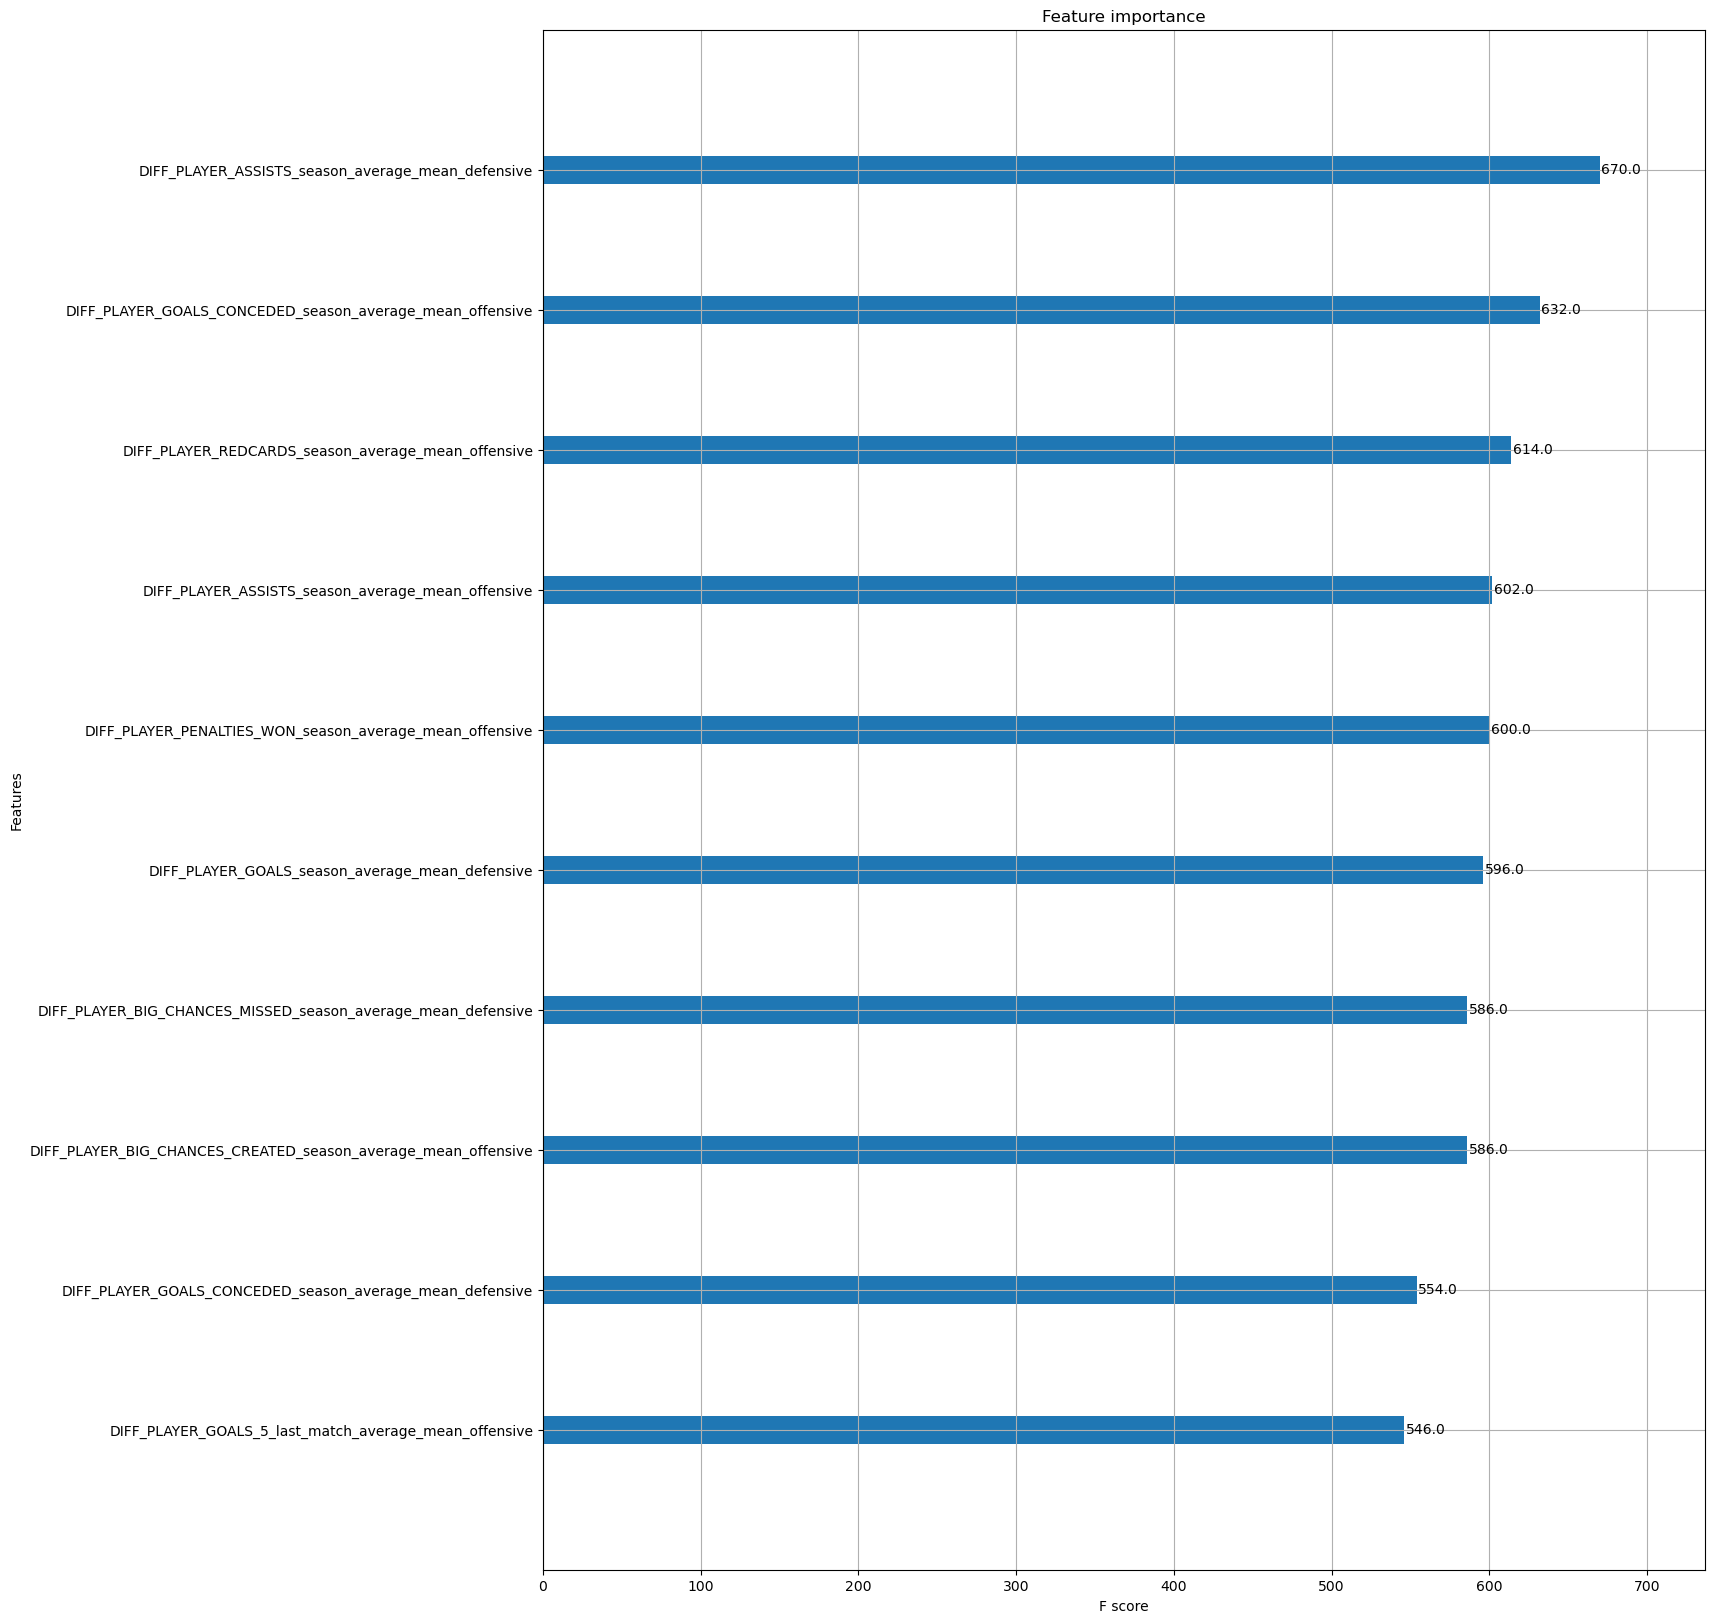

In [39]:
xgb.plot_importance(bst, max_num_features=10)
fig = plt.gcf()
fig.set_size_inches(15, 20)

In [40]:
# {feature_name: score}
importance_dict = bst.get_score(importance_type='weight')
sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
top_features = [feature for feature, score in sorted_features[:10]]
X_reduced = train_data_players[top_features]


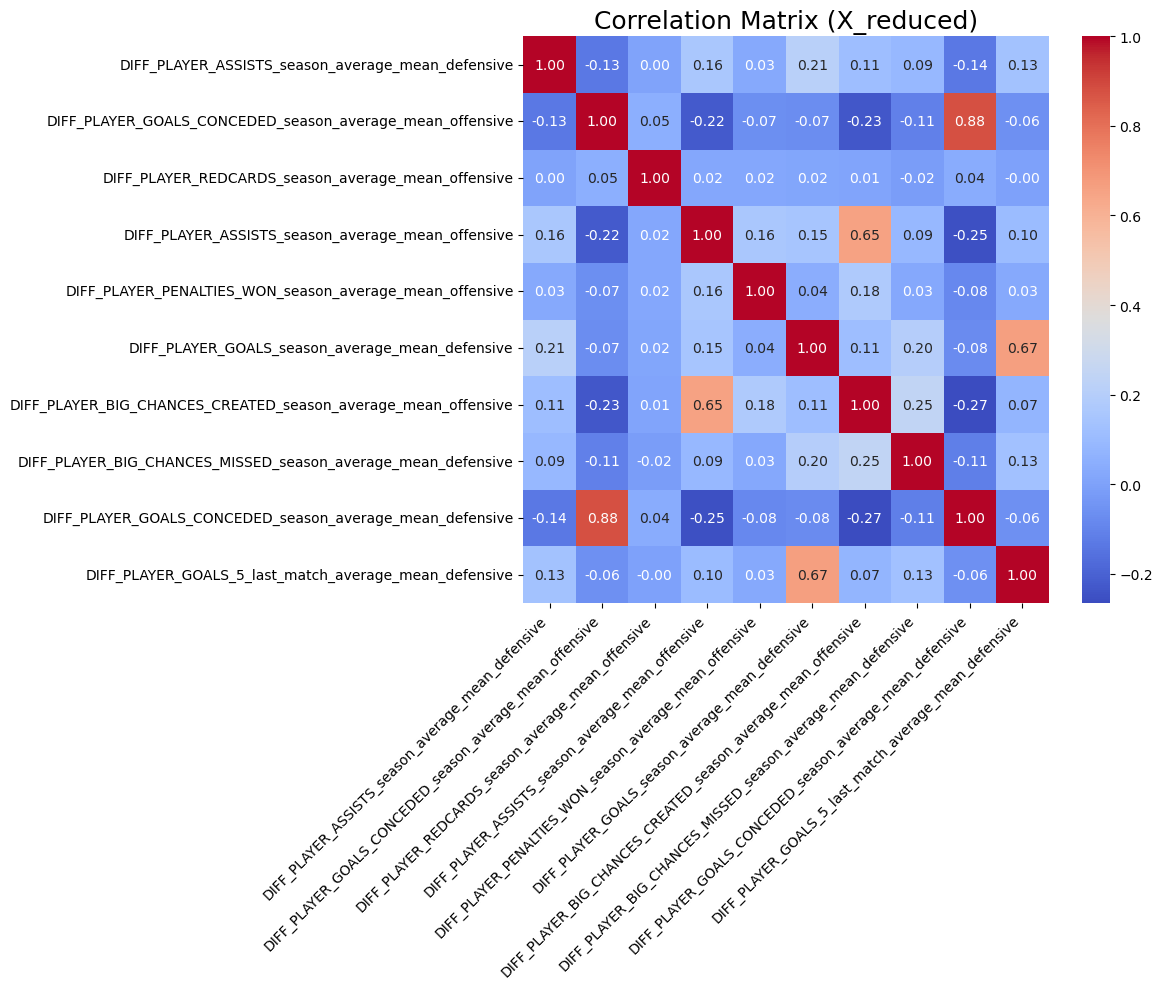

In [41]:
plot_correlation_matrix(X_reduced, title="Correlation Matrix (X_reduced)")

In [42]:
num_cols = X_reduced.select_dtypes(include=[np.number]).columns
cat_cols = X_reduced.select_dtypes(include=["object", "category"]).columns

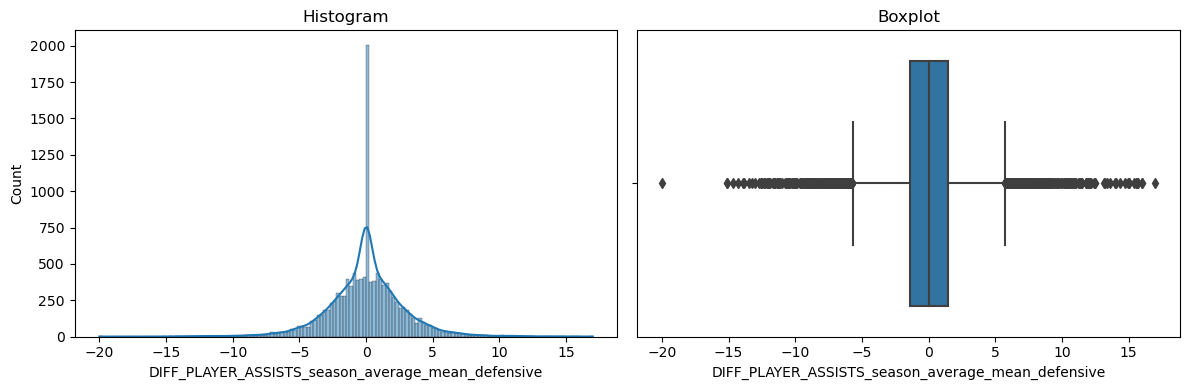

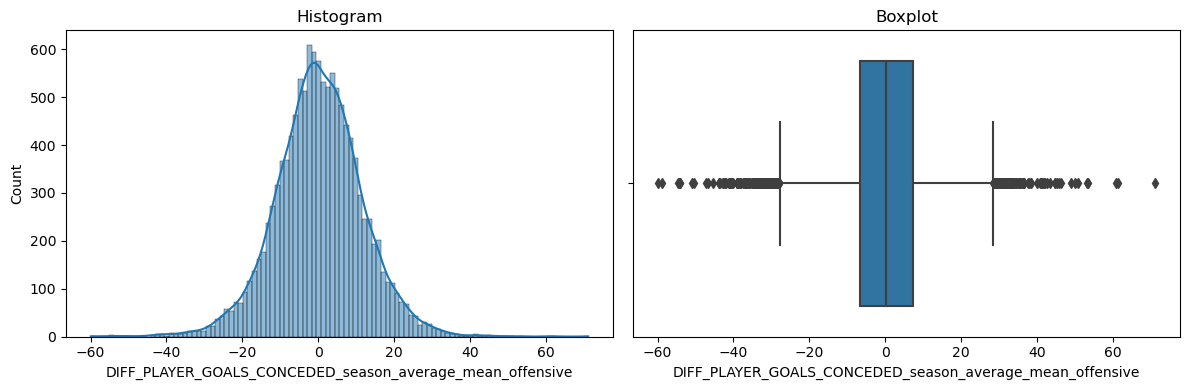

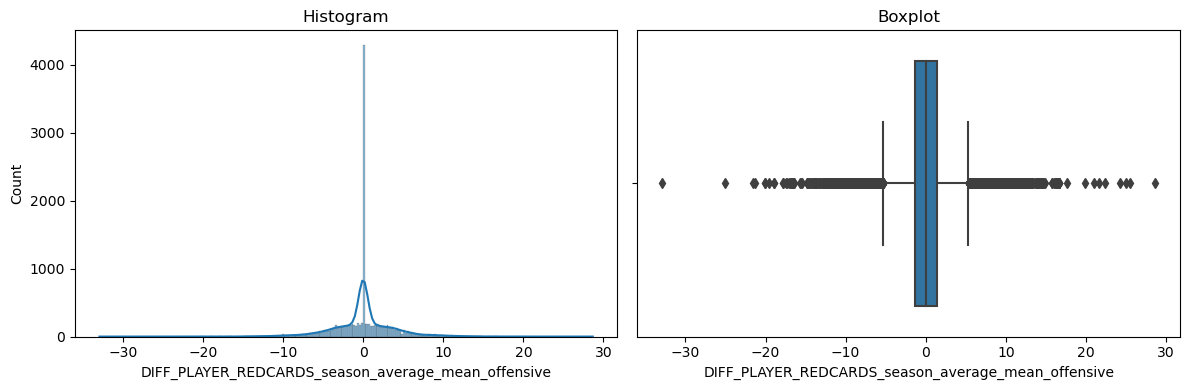

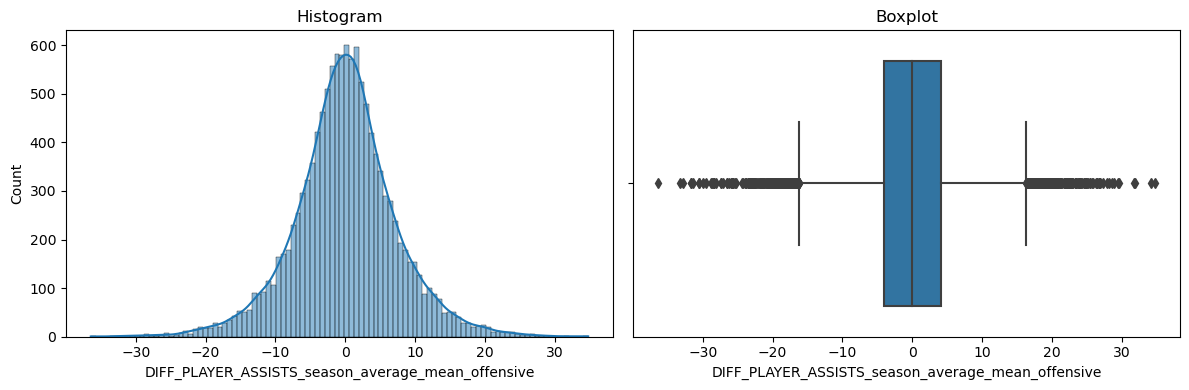

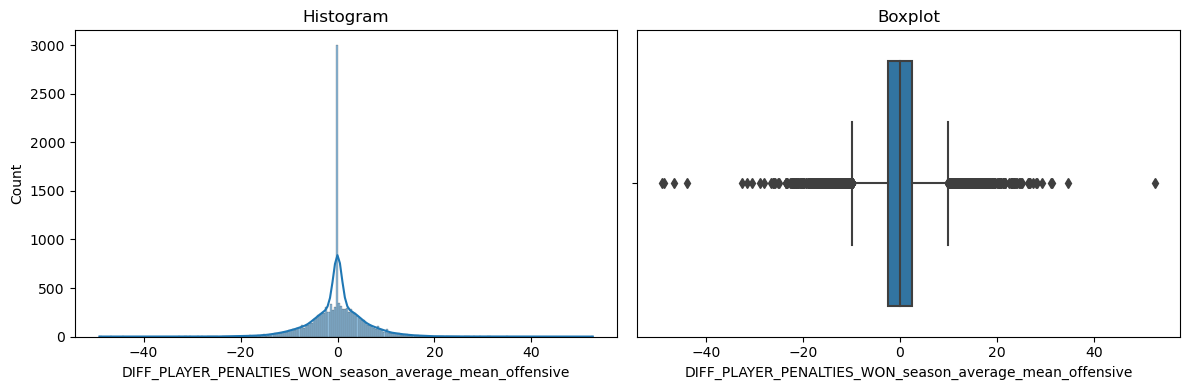

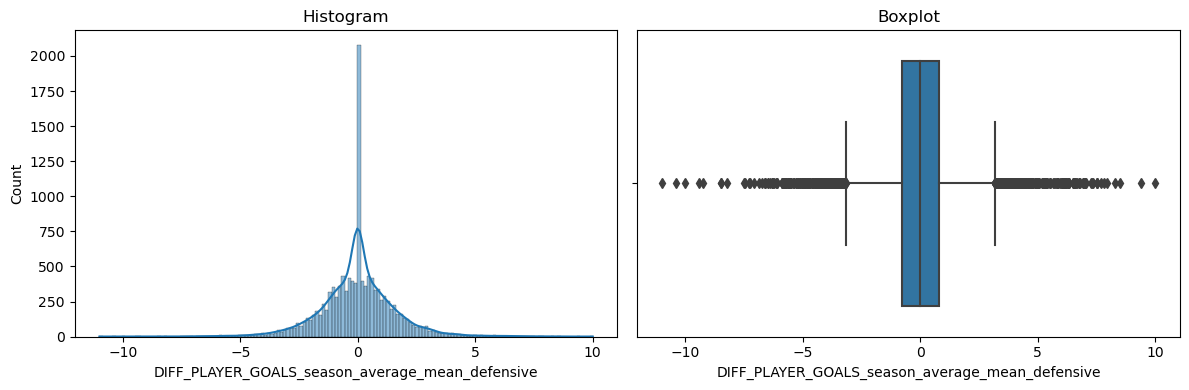

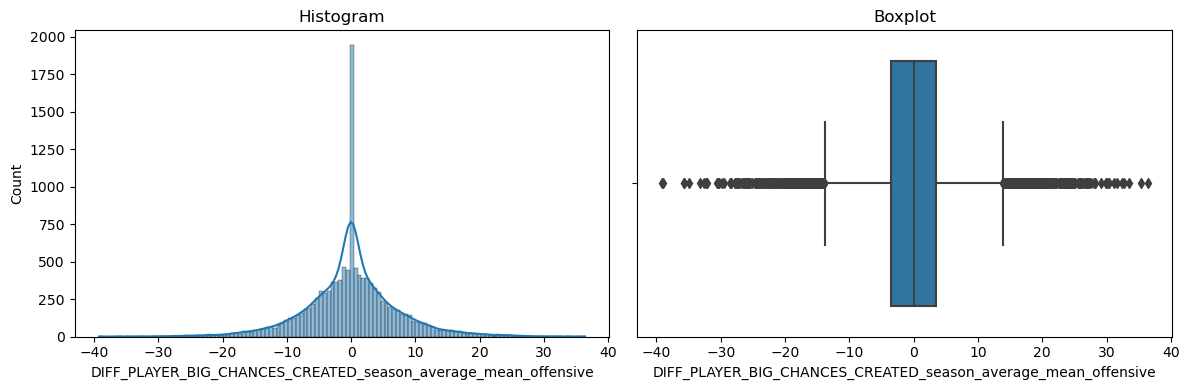

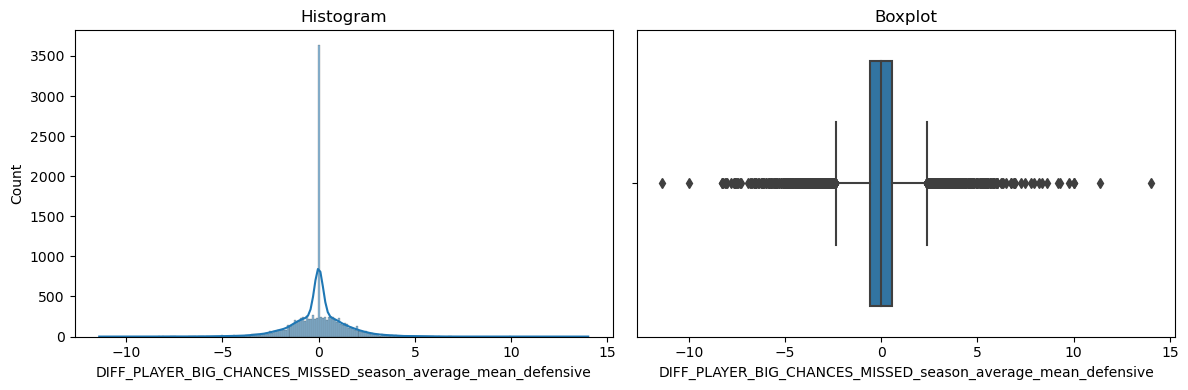

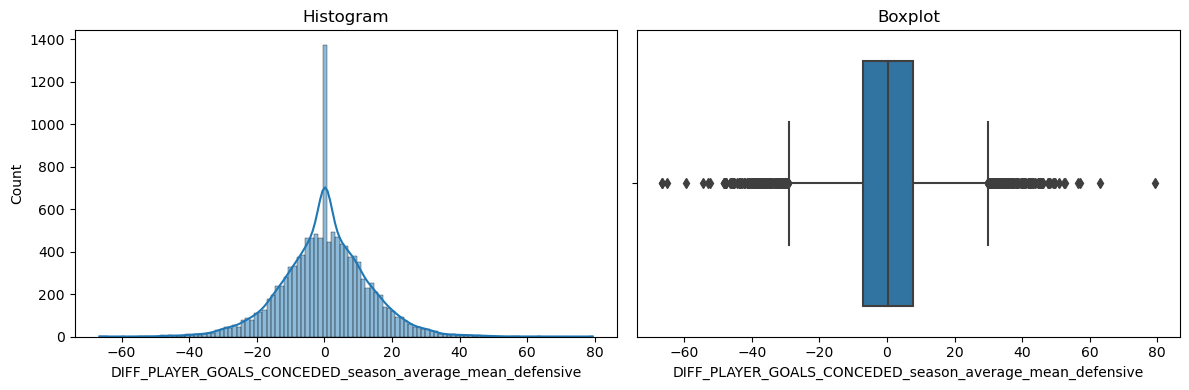

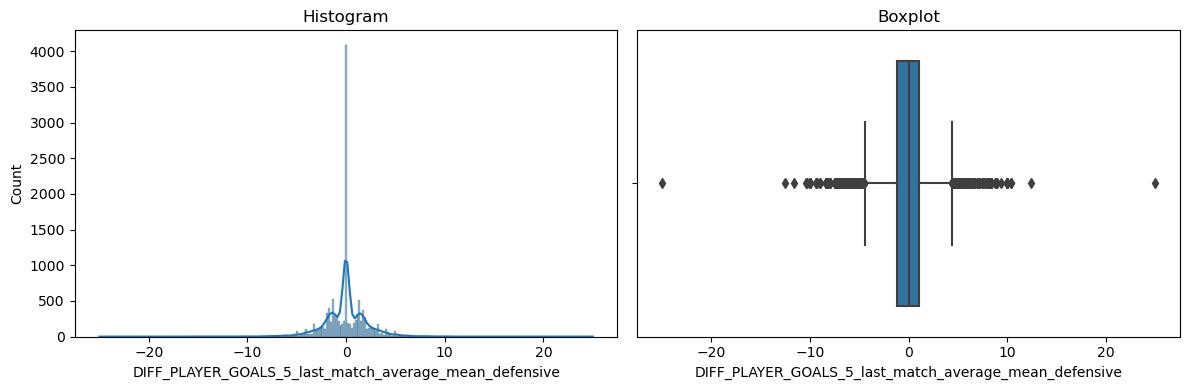

In [43]:
plot_univariate_analysis(X_reduced, numeric_cols=num_cols, categorical_cols=cat_cols)

In [44]:
# Store players training data

train_data_path = INTERIM_DATA_DIR / "train_data_players.csv"
train_data_players.to_csv(train_data_path, index=True)